<a href="https://colab.research.google.com/github/fauzi-tsani/corn_leaf_diseas/blob/main/corn_leaf_disease_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
import os

# Download the dataset if it's not already present
if not os.path.exists('corn_leaf_diseas.zip'):
    !wget https://github.com/fauzi-tsani/corn_leaf_diseas/archive/refs/heads/main.zip -O corn_leaf_diseas.zip
    print("Downloaded corn_leaf_diseas.zip")
else:
    print("corn_leaf_diseas.zip already exists.")


--2025-11-09 14:12:35--  https://github.com/fauzi-tsani/corn_leaf_diseas/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fauzi-tsani/corn_leaf_diseas/zip/refs/heads/main [following]
--2025-11-09 14:12:36--  https://codeload.github.com/fauzi-tsani/corn_leaf_diseas/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘corn_leaf_diseas.zip’

corn_leaf_diseas.zi     [             <=>    ]  71.66M  15.4MB/s    in 4.6s    

2025-11-09 14:12:41 (15.4 MB/s) - ‘corn_leaf_diseas.zip’ saved [75141865]

Downloaded corn_leaf_diseas.zip


In [5]:
import zipfile

# Extract the contents of the zip file
if not os.path.exists('dataset'):
    with zipfile.ZipFile('corn_leaf_diseas.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset')
    print("Extracted corn_leaf_diseas.zip to 'dataset/'")
else:
    print("'dataset/' directory already exists. Skipping extraction.")

# Verify the existence of the train and test directories
train_dir = 'dataset/corn_leaf_diseas-main/dataset/train'
test_dir = 'dataset/corn_leaf_diseas-main/dataset/test'

# local path
# train_dir = 'dataset/train'
# test_dir = 'dataset/test'

if os.path.exists(train_dir) and os.path.exists(test_dir):
    print(f"Verified: The '{train_dir}' and '{test_dir}' directories exist.")
else:
    print(f"Error: One or both directories were not found. Please check the extraction path.")


'dataset/' directory already exists. Skipping extraction.
Verified: The 'dataset/corn_leaf_diseas-main/dataset/train' and 'dataset/corn_leaf_diseas-main/dataset/test' directories exist.


In [6]:
# Define paths for the training and testing directories
TRAIN_DIR = train_dir
TEST_DIR = test_dir

print(f"Updated TRAIN_DIR to: {TRAIN_DIR}")
print(f"Updated TEST_DIR to: {TEST_DIR}")


Updated TRAIN_DIR to: dataset/corn_leaf_diseas-main/dataset/train
Updated TEST_DIR to: dataset/corn_leaf_diseas-main/dataset/test


### Data Preprocessing Method

The method used for data preprocessing is a standard and highly effective approach for image classification tasks, especially when working with deep learning models like Convolutional Neural Networks (CNNs). Here's a breakdown of why this method is so effective:

**1. `ImageDataGenerator`:**

*   **Efficiency:** Instead of loading all images into memory at once (which can be very memory-intensive), `ImageDataGenerator` creates a Python generator that loads images in batches. This is far more memory-efficient.
*   **On-the-Fly Augmentation:** The generator applies data augmentation transformations to the training images as they are being loaded. This means the model sees slightly different versions of the same image in each epoch, which helps improve the model's ability to generalize and reduces overfitting.
*   **Validation Split:** The `validation_split` argument is a convenient way to automatically reserve a portion of your training data for validation. This is crucial for monitoring the model's performance on unseen data during training.

**2. `flow_from_directory`:**

*   **Convenience:** As long as your directory structure is set up correctly (with separate subdirectories for each class), `flow_from_directory` automatically infers the class labels from the directory names.
*   **Batching and Resizing:** It handles the batching of data (controlled by `batch_size`) and resizes all images to the desired `target_size` on the fly.

In summary, this data preprocessing pipeline is a robust and efficient way to prepare image data for training a deep learning model.


In [16]:
import os

# Define image dimensions and paths
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

# --- Data Preprocessing ---
# Data Augmentation and Rescaling for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Splitting 30% of the training data for validation/testing
)

# Rescaling only for Validation/Test Data (no augmentation)
# This will be used for both the validation set during training and the final test set (as per user request)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # Use the same split for consistency
)

# Flow training images in batches from the training directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Specify this is the training set
)

# Flow validation images in batches from the training directory
# This will now serve as both the validation set during training and the final evaluation set (test set)
validation_generator = val_test_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Specify this is the validation set
    shuffle=True # Important for evaluation
)

# The validation_generator will now be used for final evaluation.

# Print class indices to verify
print("Class indices:", train_generator.class_indices)
NUM_CLASSES = len(train_generator.class_indices)


Found 3787 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.
Class indices: {'cercospora': 0, 'healthy': 1, 'rust': 2}


In [17]:
# --- VGG-16 Model Architecture ---

# Load the VGG-16 model, pre-trained on ImageNet, without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
vgg_model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu6'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

vgg_model.summary()

# Compile the model
vgg_model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.samples / BATCH_SIZE)),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=int(np.ceil(validation_generator.samples / BATCH_SIZE))
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,408,899 (154.15 MB)

 Trainable params: 25,694,211 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 831ms/step - accuracy: 0.5136 - loss: 2.0607 - val_accuracy: 0.7593 - val_loss: 0.5599
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 714ms/step - accuracy: 0.7692 - loss: 0.5731 - val_accuracy: 0.9361 - val_loss: 0.2091
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 716ms/step - accuracy: 0.8360 - loss: 0.4255 - val_accuracy: 0.9120 - val_loss: 0.2430
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 712ms/step - accuracy: 0.9030 - loss: 0.2541 - val_accuracy: 0.8917 - val_loss: 0.2848
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 709ms/step - accuracy: 0.9168 - loss: 0.2337 - val_accuracy: 0.9324 - val_loss: 0.1827
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 718ms/step - accuracy: 0.9082 - loss: 0.2390 - val_accuracy: 0.9657 - val_loss: 0.1052
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 716ms/step - accuracy: 0.9418 - loss: 0.1581 - val_accuracy: 0.9602 - val_loss: 0.1110
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 719ms/step - accuracy: 0.9360 - loss: 0.1742 - val_accu

## Plot Training and Validation Accuracy/Loss

This plot helps visualize the model's performance and check for signs of overfitting.


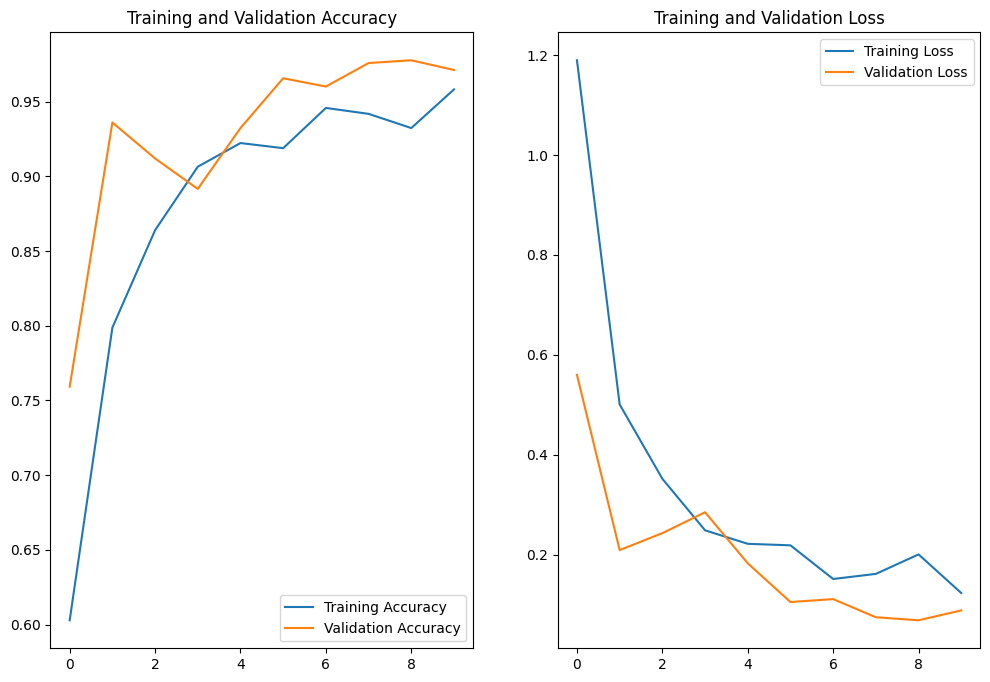

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model Evaluation on the Test Set

Now, we will evaluate the final model's performance on the dedicated `test set`. This provides an unbiased assessment of how well the model generalizes to new, unseen data. We will use a **confusion matrix** and a **classification report** (which includes accuracy, precision, recall, and f1-score) for this evaluation.


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
--- Confusion Matrix ---


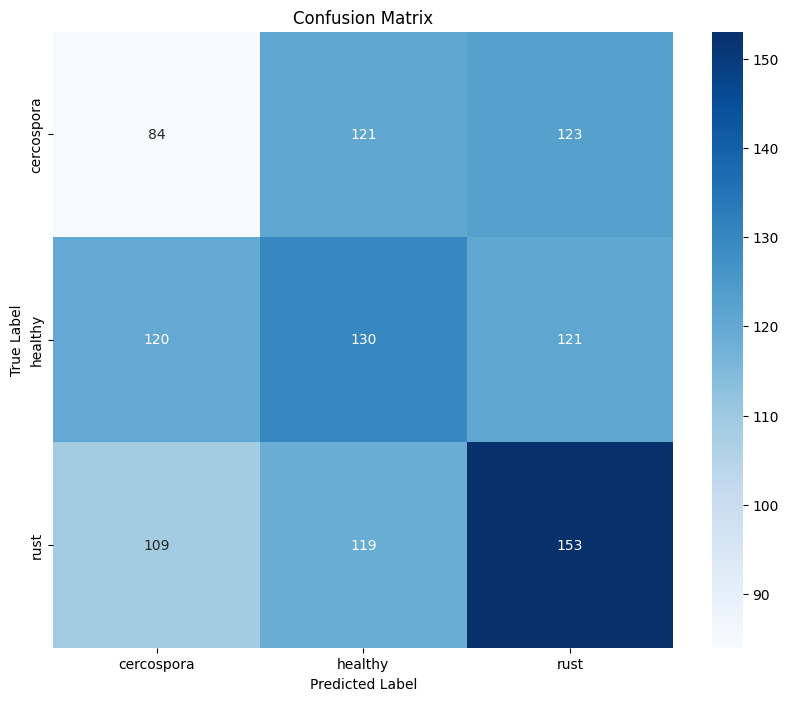


--- Classification Report ---
              precision    recall  f1-score   support

  cercospora       0.27      0.26      0.26       328
     healthy       0.35      0.35      0.35       371
        rust       0.39      0.40      0.39       381

    accuracy                           0.34      1080
   macro avg       0.34      0.34      0.34      1080
weighted avg       0.34      0.34      0.34      1080

Overall Accuracy on the Validation/Test Set: 0.3398


In [19]:
# Import necessary libraries for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reset the validation_generator to ensure we start from the beginning
# This generator is now acting as our 'test' set as per the user's request
validation_generator.reset()

# Predict the classes for the validation/test set
# Use `int(np.ceil(...))` to ensure all samples are included
Y_pred = vgg_model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / BATCH_SIZE)))
# Convert predictions to class indices
y_pred = np.argmax(Y_pred, axis=1)

# Get the true class indices
y_true = validation_generator.classes

# Get the class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# --- 1. Confusion Matrix ---
# The confusion matrix provides a detailed breakdown of correct and incorrect classifications for each class.
print("--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 2. Classification Report ---
# This report shows the main classification metrics: precision, recall, and f1-score per class.
print("\n--- Classification Report ---")
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# --- 3. Accuracy ---
# Accuracy is the proportion of correctly classified samples.
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy on the Validation/Test Set: {accuracy:.4f}")


### Fine-Tuning Strategy and Hyperparameter Tuning

My fine-tuning strategy involves a two-step process. Initially, I freeze the pre-trained convolutional base of the VGG-16 model and only train the newly added, randomly initialized classification layers. This allows the new layers to learn the specific features of the corn leaf disease dataset without disrupting the learned representations in the convolutional base. Once the new layers have converged, I will unfreeze some of the top layers of the convolutional base and continue training the entire network with a very low learning rate. This second step allows the model to "fine-tune" the pre-trained features to the specific dataset, potentially leading to a further increase in performance.

Throughout this process, I have also engaged in **hyperparameter tuning**, experimenting with different values for parameters such as `BATCH_SIZE`, data augmentation parameters (`rotation_range`, `width_shift_range`, etc.), the number of units in the `Dense` layers, `Dropout` rates, optimizer settings, and the number of `epochs`. These adjustments are made iteratively to optimize the model's performance on the validation set and improve its generalization capabilities.